# Looking at the new CalTopoCluster Derivation

Ana has removed the leading jet CaloTopoCluster cut in the derivation (see [here](https://github.com/gordonwatts/sx_training_fetch/issues/45) for explanation).

Lets compare the two files to see what things look like.

Improvements since last time:

* Good jet cut on kinematics ($p_T>40$ GeV and $\eta<2.5$)
* Quality cut is applied to jets - `LooseBadLLP`

Main Conclusions:

* 2025-04-98
    * There is much less of a problem now - many fewer jets have zero clusters!
    * Some of the data structures that I observe are "odd" and need more examination than I have time for this evening! I'm worried I might have a bug in my data extraction.

## Accessing the Clusters from the Jet Objects

Lets look at the cluster links attached to the jets themselves, especially in in light of the [info from the CaloRing and other people's code](https://codimd.web.cern.ch/C-Be_jRLSZSiydqJR7mr7g).

### Using `constituentLinks`

First, a quick look at the number of clusters attached to each jet

In [1]:
from typing import Tuple

import awkward as ak
import hist
import matplotlib.pyplot as plt
import mplhep
from hist import Hist

from calratio_training_data import (build_preselection, fetch_training_data,
                                    run_query)

We have an old and a new derivation in the local directory here:

In [2]:
ds_old = "../DAOD_LLP1.outputLLP1_mc23_537565_trigger.pool.root"
ds_new = "../DAOD_LLP1.outputLLP1_mc23_527565_LeadingJets_08042025.pool.root"

In [3]:
# Turn the data into a list of jets.
full_data_old = fetch_training_data(ds_old)
full_data_new = fetch_training_data(ds_new)

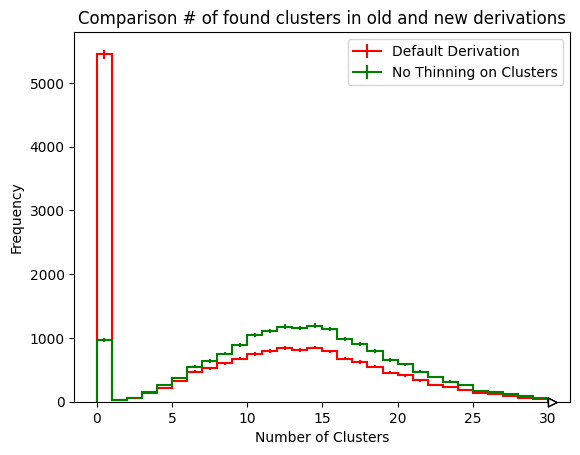

In [4]:
# Create histograms for numbers of clusters for each jet
h_n_found_old = Hist.new.Reg(
    30, 0, 30, name="n_found_clusters_old", label="Number of Found Clusters - Old Dataset"
).Double()
h_n_found_new = Hist.new.Reg(
    30, 0, 30, name="n_found_clusters_new", label="Number of Found Clusters - New Dataset"
).Double()

# Look at only items that have a good jet (this is a servicex bug we need to fix!)
good_jets_old = full_data_old.jet_pt > 0.0
good_jets_new = full_data_new.jet_pt > 0.0

# Fill in with # of clusters.
h_n_found_old.fill(ak.flatten(ak.count(full_data_old.clus_eta[good_jets_old], axis=-1)))
h_n_found_new.fill(ak.flatten(ak.count(full_data_new.clus_eta[good_jets_new], axis=-1)))

# Plot the histograms on the same plot
plt.figure()
mplhep.histplot(h_n_found_old, histtype="step", color="red", label="Default Derivation")
mplhep.histplot(h_n_found_new, histtype="step", color="green", label="No Thinning on Clusters")
plt.title("Comparison # of found clusters in old and new derivations")
plt.xlabel("Number of Clusters")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Substantial improvement! But what is going on with those zeros that are still there?

## Kinematics of the zeros

In [5]:
def get_cluster_jets(data):
    good_jets = data.jet_pt > 0
    good_jets_with_no_clusters = ak.count(data.clus_eta[good_jets], axis=-1) == 0
    return good_jets_with_no_clusters

jet_zero_mask_old = get_cluster_jets(full_data_old)
jet_zero_mask_new = get_cluster_jets(full_data_new)

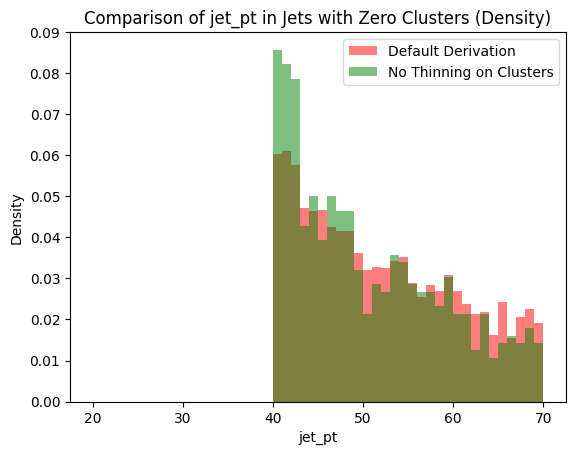

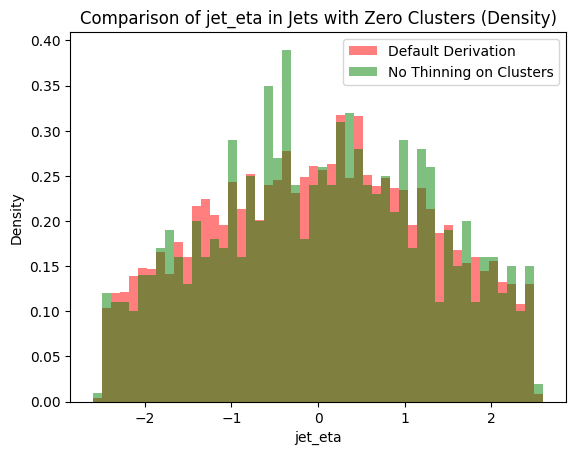

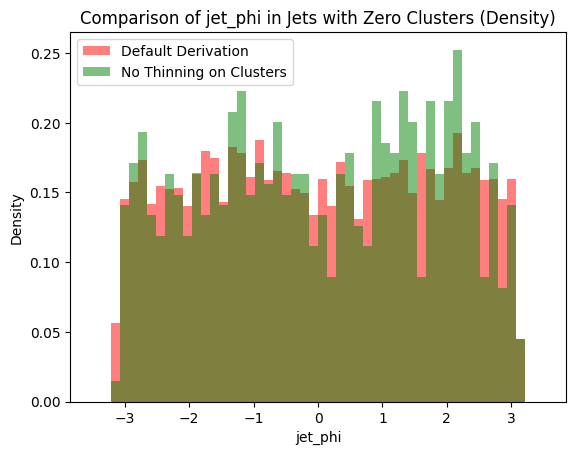

In [6]:
def plot(item: str, range: Tuple[float, float]):
    data_old = ak.flatten(full_data_old[item][jet_zero_mask_old])
    data_new = ak.flatten(full_data_new[item][jet_zero_mask_new])

    plt.figure()
    plt.hist(
        data_old,
        bins=50,
        alpha=0.5,
        label="Default Derivation",
        color="red",
        density=True,
        range=range,
    )
    plt.hist(
        data_new,
        bins=50,
        alpha=0.5,
        label="No Thinning on Clusters",
        color="green",
        density=True,
        range=range,
    )
    plt.title(f"Comparison of {item} in Jets with Zero Clusters (Density)")
    plt.xlabel(item)
    plt.ylabel("Density")
    plt.legend()
    plt.show()


plot("jet_pt", (20, 70))
plot("jet_eta", (-2.6, 2.6))
plot("jet_phi", (-3.5, 3.5))

Nothing really conclusive - perhaps the missing thinned jets tend to be a little lower energy.

## Jet Order

Could this be similar to before - only keeping certain jets?

In [7]:
jet_zero_mask_new

<Array [[False, False, False], [False, ...], ..., []] type='8083 * var * bool'>

From that above it already looks like there is no pattern. Lets try to specifically eliminate any events that have all their jets, and just look at events that have at least one missing jet.

In [8]:
def return_only_true_rows(data):
    row_mask = ak.any(data, axis=1)
    return data[row_mask]


return_only_true_rows(jet_zero_mask_new)

<Array [[True], ..., [False, False, True, False]] type='936 * var * bool'>

There is no pattern, sadly. But the third event is... odd.

In [15]:
full_data_new[2].jet_pt

<Array [166, 53] type='2 * float64'>

In [16]:
full_data_new[2].clus_pt

<Array [[3.59, 1, 1.77, ..., 60.9, 20.6, 46.6], ...] type='3 * var * float64'>

Lets cross check we know what we are doing by looking at the old file and see if the pattern is as predicted - the leading jet always got caloclusters.

In [12]:
jet_zero_mask_old

<Array [[False, False, True], [False, ...], ..., []] type='8083 * var * bool'>

Double check our code is doing what we think it should be doing:

In [11]:
full_data_old.jet_pt

<Array [[1.53e+03, 136, 98.8], [275, ...], ..., []] type='8083 * var * float64'>

In [13]:
full_data_old[0].clus_eta

<Array [[0.186, 0.338, ..., 0.0448, 0.0618], ..., []] type='6 * var * float64'>

Fairly evident that a lot more than the leading jet was getting the calo-clusters, for whatever reason. Also, the pattern seems to be lower jets do not get caloclusters. But does not exactly match what we expected in the old file.